
### Đọc file

### Thực hiện các bước sau:
#### - Labelencoder cho các nhãn lớp
#### - Chuẩn hóa minmax

### Chuẩn bị dữ liệu:
#### - Chia dữ liệu thành 2 phần (75% train, 25% test)

### Xây dựng mô hình: Bayes,SVM, KNN
#### - Đánh giá trên tập test
#### - Với mỗi mô hình đưa ra TP,FP,TN,FN sau đó , vẽ ma trận confusion
#### - In ra các giá trị accuracy, Precision, f1, recall, in ra báo cáo 
#### - Vẽ buổi đồ cột so sánh các giá trị đánh giá trên 2 mô hình (4 biểu đồ)
#### - Tìm kiếm các tham số để cải thiện hiểu quả trên 2 mô hình sau đó lặp lại toàn bộ các bước trên
#### - Sử dụng 10 fold để đánh giá 2 mô hình với các tham số tìm được(Gồm cả thời gian huấn luyện)

In [195]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import time

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix

In [112]:
#Khai baó các giá trị tham số
TEST_SIZE = 0.25
PATH_FILE = 'pc2.csv'
RANDOM_STATE = 42
CV = 5
KFOLD = 10

In [132]:
# Read data
df = pd.read_csv(PATH_FILE, header = None)
df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
0,1,0,0,0,0,1,1.00,0,0.0,1,...,2,0.50,1,3,1,3,2,0.00,0,False
1,1,1,0,0,0,1,1.00,0,0.0,1,...,3,1.00,1,0,1,0,1,0.00,0,False
2,1,4,7,24,0,1,0.13,0,0.0,1,...,7,0.03,13,21,7,8,34,96.88,8,False
3,1,1,11,3,0,1,0.08,0,0.0,1,...,3,0.06,29,48,13,7,17,93.33,12,False
4,1,1,0,0,0,1,1.00,0,0.0,1,...,3,0.33,5,4,4,1,3,0.00,1,False
5,1,1,0,0,0,1,1.00,0,0.0,1,...,3,1.00,1,1,1,1,1,0.00,0,False
6,1,0,1,0,0,1,0.50,0,0.0,1,...,2,0.33,4,7,4,7,3,50.00,2,False
7,3,1,1,0,6,2,1.00,2,3.0,1,...,5,0.50,5,9,4,7,4,50.00,2,False
8,1,0,1,0,0,1,0.50,0,0.0,1,...,2,0.25,2,3,2,3,4,50.00,2,False
9,5,1,9,10,6,3,0.25,2,3.0,2,...,8,0.13,27,37,10,14,24,86.36,12,False


In [138]:
#Kiểm tra dữ liệu
check_nan = df.isna().any().any()
if check_nan == True:
    print("Dữ liệu bị thiếu.")
else:
    print("Dữ liệu đầy đủ.")

Dữ liệu đầy đủ.


In [168]:
df_X = df.iloc[:,:-1]
df_y = df.iloc[:,-1]

df_X.shape, df_y.shape

#Kiểm tra tính cân bằng
df_y.value_counts()

#LableEncoder
le = LabelEncoder()
df.iloc[:,-1] = le.fit_transform(df.iloc[:,-1])
df

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
0,1,0,0,0,0,1,1.00,0,0.0,1,...,2,0.50,1,3,1,3,2,0.00,0,0
1,1,1,0,0,0,1,1.00,0,0.0,1,...,3,1.00,1,0,1,0,1,0.00,0,0
2,1,4,7,24,0,1,0.13,0,0.0,1,...,7,0.03,13,21,7,8,34,96.88,8,0
3,1,1,11,3,0,1,0.08,0,0.0,1,...,3,0.06,29,48,13,7,17,93.33,12,0
4,1,1,0,0,0,1,1.00,0,0.0,1,...,3,0.33,5,4,4,1,3,0.00,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5584,1,5,6,41,0,1,0.14,0,0.0,1,...,9,0.02,15,23,11,5,50,97.92,7,0
5585,3,2,2,0,4,2,0.67,2,2.0,2,...,8,0.40,8,11,3,8,5,66.67,3,0
5586,1,0,1,2,0,1,0.50,0,0.0,1,...,2,0.17,1,5,1,5,6,75.00,2,0
5587,1,1,1,0,0,1,0.50,0,0.0,1,...,3,0.17,3,5,3,5,6,50.00,2,0


In [170]:
#Minmax Scale
scaler = MinMaxScaler()
df_X = scaler.fit_transform(df_X)
df_X, df_y

(array([[0.        , 0.        , 0.        , ..., 0.00129032, 0.        ,
         0.        ],
        [0.        , 0.01351351, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.05405405, 0.0125448 , ..., 0.04258065, 0.97779572,
         0.01206637],
        ...,
        [0.        , 0.        , 0.00179211, ..., 0.00645161, 0.75696407,
         0.00301659],
        [0.        , 0.01351351, 0.00179211, ..., 0.00645161, 0.50464271,
         0.00301659],
        [0.00699301, 0.02702703, 0.00358423, ..., 0.00516129, 0.67289059,
         0.00452489]]),
 0       0
 1       0
 2       0
 3       0
 4       0
        ..
 5584    0
 5585    0
 5586    0
 5587    0
 5588    0
 Name: 36, Length: 5589, dtype: int64)

In [172]:
#Chia dữ liệu
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size= TEST_SIZE, random_state= RANDOM_STATE)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4191, 36), (1398, 36), (4191,), (1398,))

In [197]:
#Hàm tính toán Positive, Negative
def calPN(a, b):
    matrix = confusion_matrix(a, b)
    metrix = {}
    for i in range(matrix.shape[0]):
        TP = matrix[i, i]
        FP = matrix[:, i].sum() - TP
        FN = matrix[i, :].sum() - TP
        TN = matrix.sum() - (FP + FN + TP)
        
        # Lưu lại các giá trị vào metrix cho từng lớp
        metrix[i] = {
            'TP': TP,
            'FP': FP,
            'FN': FN,
            'TN': TN
        }
    return metrix,matrix

## Xây dựng mô hình

Độ chính xác của NaiveBayes:  0.9606580829756796
(0, {'TP': 1340, 'FP': 3, 'FN': 52, 'TN': 3})
(1, {'TP': 3, 'FP': 52, 'FN': 3, 'TN': 1340})
Ma trận nhầm lẫn: 

[[1340   52]
 [   3    3]]


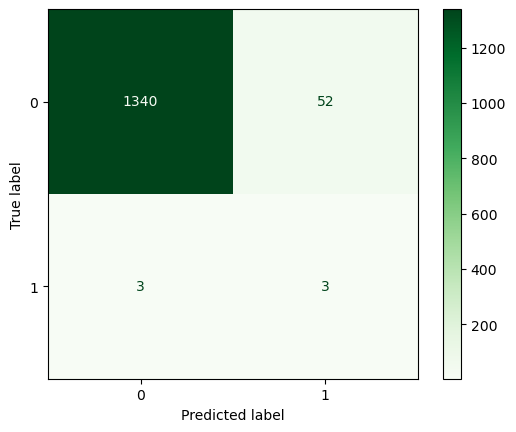

Báo cáo: 
               precision    recall  f1-score   support

           0       1.00      0.96      0.98      1392
           1       0.05      0.50      0.10         6

    accuracy                           0.96      1398
   macro avg       0.53      0.73      0.54      1398
weighted avg       0.99      0.96      0.98      1398

Accuracy NB:  0.9606580829756796
Precision NB:  0.9977661950856291
Recall NB:  0.9626436781609196
F1-score NB:  0.979890310786106


In [242]:
#NAIVE_BAYES
#Khởi tạo mô hình
nb = GaussianNB()

#Huấn luyện mô hình
nb.fit(X_train, y_train)

#Dự đoán
y_predNB = nb.predict(X_test)

#Độ chính xác
accuracyNB = accuracy_score(y_test, y_predNB)
print("Độ chính xác của NaiveBayes: ", accuracyNB)

#TP, FP, TN, FN
dicNB, matrixNB = calPN(y_test, y_predNB)
for x in dicNB.items():
    print(x)

#ConfusionMatrix
print("Ma trận nhầm lẫn: \n")
print(matrixNB)
disp = ConfusionMatrixDisplay(confusion_matrix= matrixNB)
disp.plot(cmap = 'Greens')
plt.show()

#Báo cáo đánh giá và in các giá trị đánh giá
print("Báo cáo: \n", classification_report(y_test, y_predNB))
reportNB = classification_report(y_test, y_predNB, output_dict= True)

accNB = reportNB['accuracy']
preNB = reportNB['0']['precision']
recNB = reportNB['0']['recall']
f1NB = reportNB['0']['f1-score']

print("Accuracy NB: ", accNB)
print("Precision NB: ", preNB)
print("Recall NB: ", recNB)
print("F1-score NB: ", f1NB)

Độ chính xác của KNN: 0.9957081545064378
(0, {'TP': 1392, 'FP': 6, 'FN': 0, 'TN': 0})
(1, {'TP': 0, 'FP': 0, 'FN': 6, 'TN': 1392})
Ma trận nhầm lẫn: 

[[1392    0]
 [   6    0]]


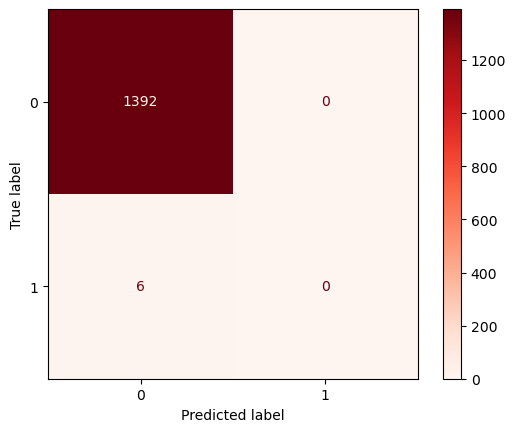

Báo cáo: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1392
           1       0.00      0.00      0.00         6

    accuracy                           1.00      1398
   macro avg       0.50      0.50      0.50      1398
weighted avg       0.99      1.00      0.99      1398

Accuracy KNN:  0.9957081545064378
Precision KNN:  0.9957081545064378
Recall KNN:  1.0
F1-score KNN:  0.9978494623655914


In [250]:
#KNN
#Khởi tạo mô hình
clf_knn = KNeighborsClassifier()

#Huấn luyện mô hình
clf_knn.fit(X_train, y_train)

#Dự đoán
y_predKNN = clf_knn.predict(X_test)

#Độ chính xác
accuracyKNN = accuracy_score(y_test, y_predKNN)
print("Độ chính xác của KNN:", accuracyKNN)

#TP, FP, TN, FN
dicKNN, matrixKNN = calPN(y_test, y_predKNN)
for x in dicKNN.items():
    print(x)

#ConfusionMatrix
print("Ma trận nhầm lẫn: \n")
print(matrixKNN)
disp = ConfusionMatrixDisplay(confusion_matrix= matrixKNN)
disp.plot(cmap = 'Reds')
plt.show()

#Báo cáo đánh giá và in các giá trị đánh giá
print("Báo cáo: \n", classification_report(y_test, y_predKNN))
reportKNN = classification_report(y_test, y_predKNN, output_dict= True)

accKNN = reportKNN['accuracy']
preKNN = reportKNN['0']['precision']
recKNN = reportKNN['0']['recall']
f1KNN = reportKNN['0']['f1-score']

print("Accuracy KNN: ", accKNN)
print("Precision KNN: ", preKNN)
print("Recall KNN: ", recKNN)
print("F1-score KNN: ", f1KNN)

Độ chính xác của SVM:  0.9957081545064378
(0, {'TP': 1392, 'FP': 6, 'FN': 0, 'TN': 0})
(1, {'TP': 0, 'FP': 0, 'FN': 6, 'TN': 1392})
Ma trận nhầm lẫn: 

[[1392    0]
 [   6    0]]


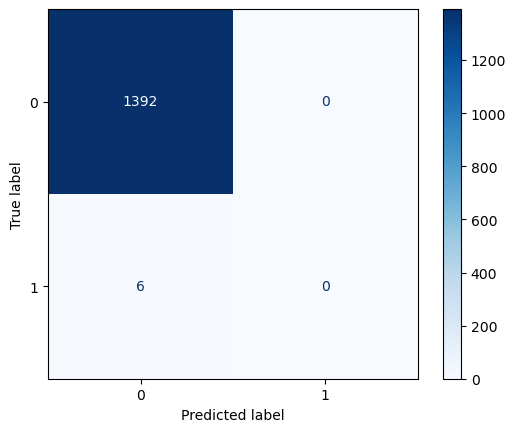

Báo cáo: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1392
           1       0.00      0.00      0.00         6

    accuracy                           1.00      1398
   macro avg       0.50      0.50      0.50      1398
weighted avg       0.99      1.00      0.99      1398

Accuracy SVM:  0.9957081545064378
Precision SVM:  0.9957081545064378
Recall SVM:  1.0
F1-score SVM:  0.9978494623655914


In [252]:
#SVM
#Khởi tạo mô hình
clf_svm = SVC()

#Huấn luyện mô hình 
clf_svm.fit(X_train, y_train)

#Dự đoán
y_predSVM = clf_svm.predict(X_test)

#Độ chính xác
accuracySVM = accuracy_score(y_test, y_predSVM)
print("Độ chính xác của SVM: ", accuracySVM)

#TP, FP, TN, FN
dicSVM, matrixSVM = calPN(y_test, y_predSVM)
for x in dicSVM.items():
    print(x)

#ConfusionMatrix
print("Ma trận nhầm lẫn: \n")
print(matrixSVM)
disp = ConfusionMatrixDisplay(confusion_matrix= matrixSVM)
disp.plot(cmap = 'Blues')
plt.show()

#Báo cáo đánh giá và in các giá trị đánh giá
print("Báo cáo: \n", classification_report(y_test, y_predSVM))
reportSVM = classification_report(y_test, y_predSVM, output_dict= True)

accSVM = reportSVM['accuracy']
preSVM = reportSVM['0']['precision']
recSVM = reportSVM['0']['recall']
f1SVM = reportSVM['0']['f1-score']

print("Accuracy SVM: ", accSVM)
print("Precision SVM: ", preSVM)
print("Recall SVM: ", recSVM)
print("F1-score SVM: ", f1SVM)

## So sánh các giá trị đánh giá giữa SVM và KNN

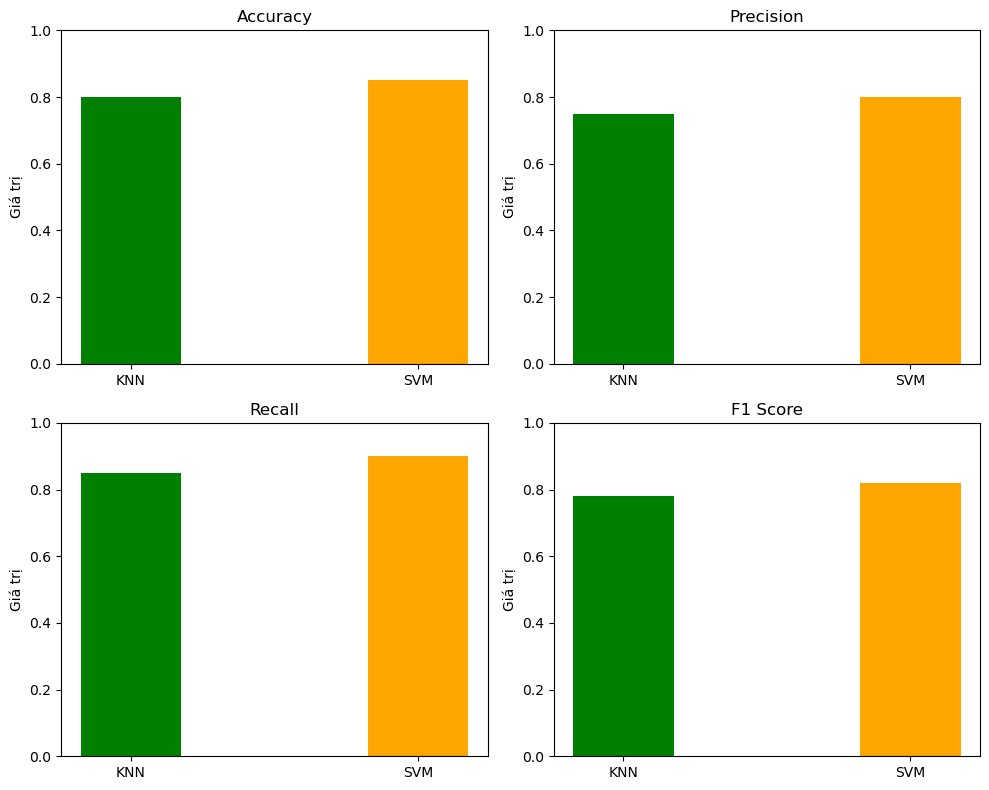

In [280]:
# Tạo danh sách các chỉ số
metrics = [
    [accKNN, accSVM],  # Accuracy
    [preKNN, preSVM],  # Precision
    [recKNN, recSVM],  # Recall
    [f1KNN, f1SVM]     # F1 Score
]

# Đặt nhãn cho các chỉ số
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# Tạo một biểu đồ lớn với 4 biểu đồ nhỏ
fig, axs = plt.subplots(2, 2, figsize=(10, 8))  # 2 hàng, 2 cột

# Vẽ từng biểu đồ nhỏ
bar_width = 0.35  # Độ rộng của cột
x = np.arange(len(metrics))  # Vị trí cho các biểu đồ nhỏ

for i in range(2):
    for j in range(2):
        index = i * 2 + j  # Tính chỉ số cho từng biểu đồ nhỏ
        axs[i, j].bar(['KNN', 'SVM'], metrics[index], width=bar_width, color=['green', 'orange'])
        axs[i, j].set_title(labels[index])
        axs[i, j].set_ylabel('Giá trị')
        axs[i, j].set_ylim(0, 1)  # Đặt giới hạn cho trục y từ 0 đến 1
        axs[i, j].set_xticks(['KNN', 'SVM'])  # Đặt nhãn cho các cột

# Tinh chỉnh khoảng cách giữa các biểu đồ
plt.tight_layout()
plt.show()

## Tối ưu tham số

In [293]:
#KNN
#Khởi tạo mô hình
modelKNN = KNeighborsClassifier()

#Lưới tham số
paramKNN = {
    'n_neighbors': np.arange(1,11),
    'weights': ['uniform','distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

gridsearch = GridSearchCV(modelKNN, param_grid= paramKNN, verbose= 2, cv= CV, scoring= 'accuracy', refit = True)
gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] END ...metric=euclidean, n_neighbors=1, weights=uniform; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=1, weights=uniform; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=1, weights=uniform; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=1, weights=uniform; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=1, weights=uniform; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=1, weights=distance; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=1, weights=distance; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=1, weights=distance; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=1, weights=distance; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=1, weights=distance; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=2, weights=uniform; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=2, we

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
                         'weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=2)

In [294]:
#Bộ tham số tối ưu
best_param_KNN = gridsearch.best_params_

#Cập nhật lại mô hình
modelKNN = KNeighborsClassifier(**best_param_KNN)

#Huấn luyện
modelKNN.fit(X_train, y_train)

y_pred = modelKNN.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1392
           1       0.00      0.00      0.00         6

    accuracy                           1.00      1398
   macro avg       0.50      0.50      0.50      1398
weighted avg       0.99      1.00      0.99      1398



In [297]:
#SVM
modelSVM = SVC()

#Lưới tham số
paramSVM = {
    'kernel': ['linear', 'rbf', 'poly','sigmoid'],
    'C': [0, 0.1, 1, 10, 100],
    'coef0': [1, 2, 3, 4],
    'degree': [1, 2, 3, 4]
}

gridsearch = GridSearchCV(modelSVM, param_grid= paramSVM, scoring= 'accuracy', verbose= 2, refit= True, cv = CV)
gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits
[CV] END ..............C=0, coef0=1, degree=1, kernel=linear; total time=   0.0s
[CV] END ..............C=0, coef0=1, degree=1, kernel=linear; total time=   0.0s
[CV] END ..............C=0, coef0=1, degree=1, kernel=linear; total time=   0.0s
[CV] END ..............C=0, coef0=1, degree=1, kernel=linear; total time=   0.0s
[CV] END ..............C=0, coef0=1, degree=1, kernel=linear; total time=   0.0s
[CV] END .................C=0, coef0=1, degree=1, kernel=rbf; total time=   0.0s
[CV] END .................C=0, coef0=1, degree=1, kernel=rbf; total time=   0.0s
[CV] END .................C=0, coef0=1, degree=1, kernel=rbf; total time=   0.0s
[CV] END .................C=0, coef0=1, degree=1, kernel=rbf; total time=   0.0s
[CV] END .................C=0, coef0=1, degree=1, kernel=rbf; total time=   0.0s
[CV] END ................C=0, coef0=1, degree=1, kernel=poly; total time=   0.0s
[CV] END ................C=0, coef0=1, degree

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0, 0.1, 1, 10, 100], 'coef0': [1, 2, 3, 4],
                         'degree': [1, 2, 3, 4],
                         'kernel': ['linear', 'rbf', 'poly', 'sigmoid']},
             scoring='accuracy', verbose=2)

In [299]:
#Bộ tham số tối ưu
best_param_SVM = gridsearch.best_params_
modelSVM = SVC(**best_param_SVM)
modelSVM.fit(X_train, y_train)
y_pred = modelSVM.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1392
           1       0.00      0.00      0.00         6

    accuracy                           0.99      1398
   macro avg       0.50      0.50      0.50      1398
weighted avg       0.99      0.99      0.99      1398



### Kiểm định chéo KFold

In [314]:
#Tạo hàm 
kf = KFold(n_splits= KFOLD, shuffle= True, random_state= RANDOM_STATE)

time_knn = []
acc_knn = []
prec_knn = []
rec_knn = []
f1_knn = []

time_svm = []
acc_svm = []
prec_svm = []
rec_svm= []
f1_svm = []

i = 1
for train_index, test_index in kf.split(df_X):
    # Chia dữ liệu thành training và testing
    Xk_train, Xk_test = df_X[train_index], df_X[test_index]
    yk_train, yk_test = df_y[train_index], df_y[test_index]
    
    # Khởi tạo mô hình SVM
    model_svm = SVC()
    
    # Khởi tạo mô hình KNN
    model_knn = KNeighborsClassifier()

    
    # Huấn luyện mô hình SVM
    start_svm = time.time()
    model_svm.fit(Xk_train, yk_train)
    end_svm = time.time() - start_svm
    
    # Huấn luyện mô hình KNN
    start_knn = time.time()
    model_knn.fit(Xk_train, yk_train)
    end_knn =  time.time() - start_knn
    
    
    
    # Dự đoán mô hình SVM
    yk_pred_svm = modelSVM.predict(Xk_test)
    
    # Dự đoán mô hình KNN
    yk_pred_knn = modelKNN.predict(Xk_test)
    
    
    # Đưa ra độ chính xác mô hình SVM
    accuracy_svm = accuracy_score(yk_test, yk_pred_svm)
    precision_svm = precision_score(yk_test, yk_pred_svm)
    recall_svm = recall_score(yk_test, yk_pred_svm)
    f1score_svm = f1_score(yk_test, yk_pred_svm)
    
    # Đưa ra độ chính xác mô hình KNN
    accuracy_knn = accuracy_score(yk_test, yk_pred_knn)
    precision_knn = precision_score(yk_test, yk_pred_knn)
    recall_knn = recall_score(yk_test, yk_pred_knn)
    f1score_knn = f1_score(yk_test, yk_pred_knn)
    
    # Append vào các độ đo SVM mảng 
    time_svm.append(end_svm)
    acc_svm.append(accuracy_svm)
    prec_svm.append(precision_svm)
    rec_svm.append(recall_svm)
    f1_svm.append(f1score_svm)
    
    # Append vào các độ đo KNN mảng 
    time_knn.append(end_knn)
    acc_knn.append(accuracy_knn)
    prec_knn.append(precision_knn)
    rec_knn.append(recall_knn)
    f1_knn.append(f1score_knn)
    
    # In kết quả
    print(f"FOLD: {i}")
    print(f"{'':<15} {'SVM':>10} {'KNN':>10}")
    print(f"{'Thời gian':<15} {end_svm:>10.2f}s {end_knn:>10.2f}s")
    print(f"{'Accuracy':<15} {accuracy_svm*100:>10.2f}% {accuracy_knn*100:>10.2f}%")
    print(f"{'Precision':<15} {precision_svm*100:>10.2f}% {precision_knn*100:>10.2f}%")
    print(f"{'Recall':<15} {recall_svm*100:>10.2f}% {recall_knn*100:>10.2f}%")
    print(f"{'F1_score':<15} {f1score_svm*100:>10.2f}% {f1score_knn*100:>10.2f}%")
    print("###########################################")
    
    i = i + 1

FOLD: 1
                       SVM        KNN
Thời gian             0.03s       0.00s
Accuracy             99.46%      99.46%
Precision             0.00%       0.00%
Recall                0.00%       0.00%
F1_score              0.00%       0.00%
###########################################
FOLD: 2
                       SVM        KNN
Thời gian             0.03s       0.00s
Accuracy             99.82%      99.82%
Precision             0.00%       0.00%
Recall                0.00%       0.00%
F1_score              0.00%       0.00%
###########################################
FOLD: 3
                       SVM        KNN
Thời gian             0.03s       0.00s
Accuracy             99.64%      99.64%
Precision             0.00%       0.00%
Recall                0.00%       0.00%
F1_score              0.00%       0.00%
###########################################
FOLD: 4
                       SVM        KNN
Thời gian             0.02s       0.00s
Accuracy             99.46%      99.46%
Prec

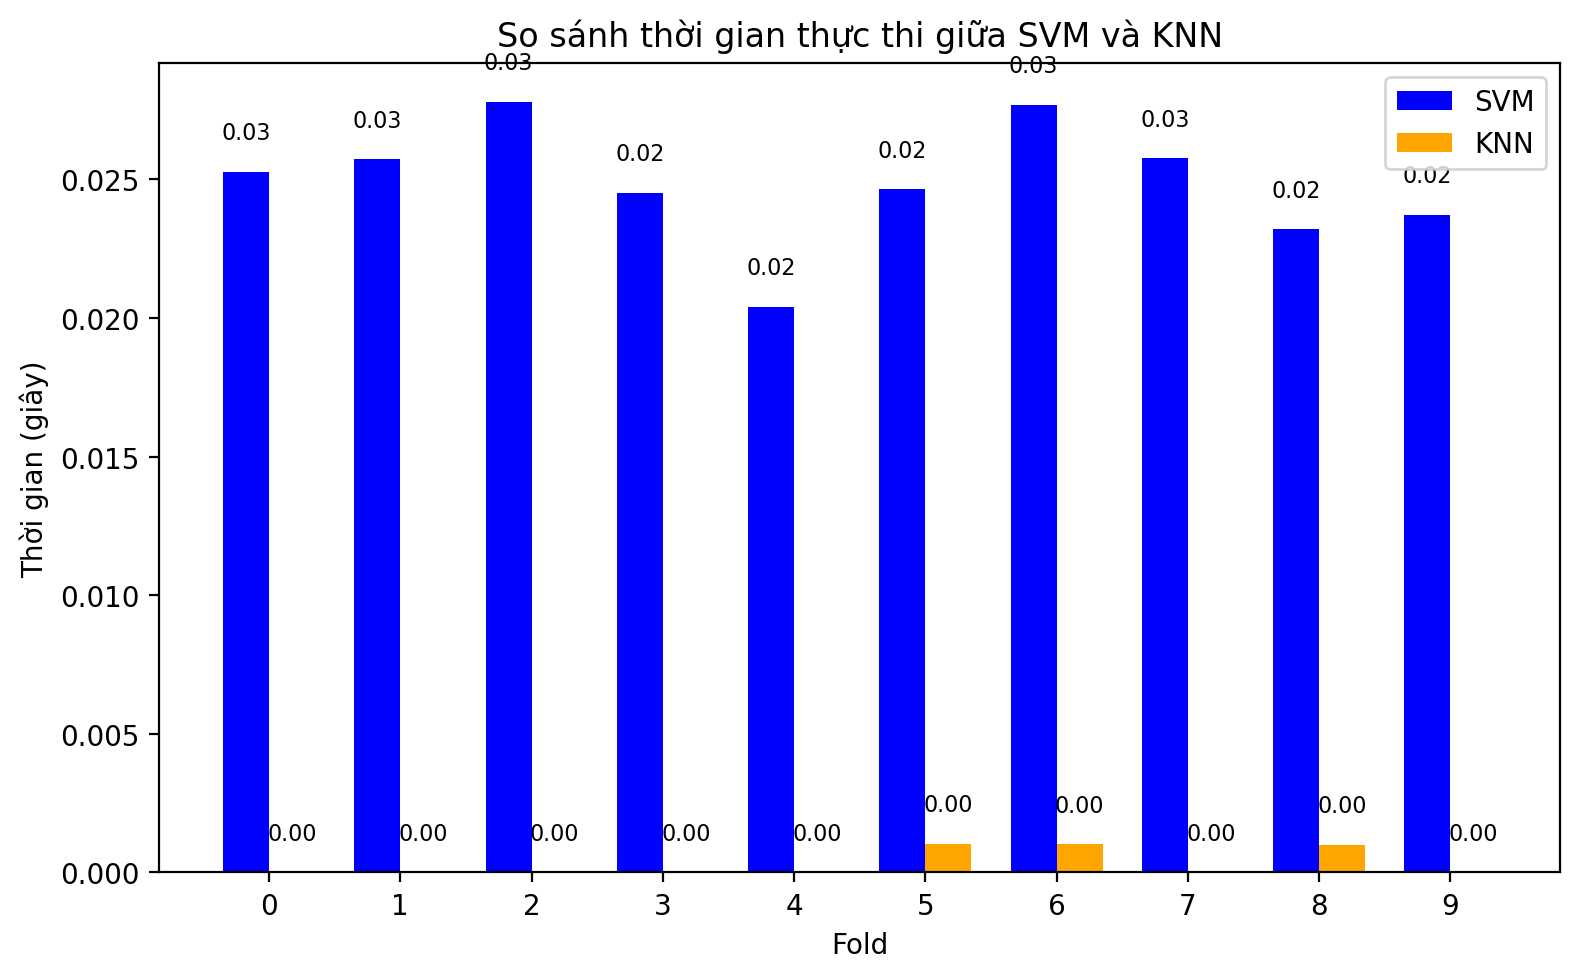

In [316]:
# Vẽ biểu đồ 
x = np.arange(len(time_svm))  # Tọa độ x
width = 0.35  # Độ rộng của các cột

fig, ax = plt.subplots(figsize=(8, 5), dpi=200)
rects1 = ax.bar(x - width/2, time_svm, width, label='SVM', color='blue')
rects2 = ax.bar(x + width/2, time_knn, width, label='KNN', color='orange')

# Gắn nhãn và tiêu đề
ax.set_xlabel('Fold')
ax.set_ylabel('Thời gian (giây)')
ax.set_title('So sánh thời gian thực thi giữa SVM và KNN')
ax.set_xticks(x)
ax.legend()

# Hiển thị giá trị trên cột
for rect in rects1 + rects2:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.001, f'{height:.2f}', ha='center', va='bottom', fontsize=8)

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()